In [19]:
import torch
import torch.nn.functional as F

dim = 4096
# dim = 1024
datatype = 'bipolar'
operation = 'MAP'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# if torch.cuda.is_available():
#     torch.set_default_device(device=device)
# else:
#     print("CUDA is not avalable. Defaulting to CPU")
device

device(type='cuda')

In [20]:
def item_memory(dim, number, datatype):
    """
    Function
    ===
    Generate random vectors

    Parameter
    ---
    The size of the vectors is (number, dim)
    Data type must be 'bipolar' by now so that the element is within {-1, 1}

    """
    if datatype != 'bipolar':
        raise ValueError('Sorry, currently only supporting bipolar datatype.')
    table = torch.randint(low=0, high=2, size=(number, dim), dtype=torch.int8)
    table[table == 0] = -1
    return table

iM = item_memory(dim=dim, number=3, datatype=datatype)
iM#, CA90(iM)

tensor([[ 1, -1, -1,  ..., -1, -1, -1],
        [-1,  1,  1,  ..., -1,  1,  1],
        [-1, -1,  1,  ..., -1, -1,  1]], dtype=torch.int8)

## Fashion Mnist 数据

加载 fashion mnist dataset，并打印数据集的一些参数

In [21]:
import sys
sys.path.insert(0, '/home/maria/py/dl/my_d2l')
from my_package import preData
from my_package import fig

dataset_path = "../../data"
batch_size = 256
train_iter, test_iter = preData.load_data_fashion_mnist(path=dataset_path, batch_size=batch_size)

In [22]:
print("Number of batches in train_loader:", len(train_iter))
print("Number of batches in test_loader:", len(test_iter))
# 获取一个批次的数据
X_train, y_train = next(iter(train_iter))

# 打印特征和标签的形状
print("Shape of each sample (features):", X_train.shape[1:])  # 去掉批次维度
print("Shape of each label:", y_train.shape[1:])  # 标签通常是一维的

# 获取所有唯一的标签
unique_labels = torch.unique(y_train)

# 打印类别的数量
print("Number of classes:", len(unique_labels))


Number of batches in train_loader: 235
Number of batches in test_loader: 40
Shape of each sample (features): torch.Size([1, 28, 28])
Shape of each label: torch.Size([])
Number of classes: 10


array([<Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 'pullover'}>,
       <Axes: title={'center': 'trouser'}>,
       <Axes: title={'center': 'trouser'}>,
       <Axes: title={'center': 'shirt'}>,
       <Axes: title={'center': 'trouser'}>,
       <Axes: title={'center': 'coat'}>,
       <Axes: title={'center': 'shirt'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sneaker'}>,
       <Axes: title={'center': 'coat'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sneaker'}>,
       <Axes: title={'center': 'dress'}>,
       <Axes: title={'center': 'coat'}>,
       <Axes: title={'center': 'trouser'}>,
       <Axes: title={'center': 'pullover'}>,
       <Axes: title={'center': 'coat'}>], dtype=object)

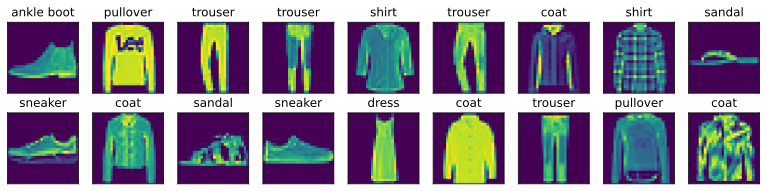

In [23]:
X, y = next(iter(test_iter))
fig.show_mnist_images(X.reshape(batch_size, 28, 28), 2, 9, titles=preData.get_fashion_mnist_labels(y))

### 直接对数据集进行转换的方式

In [ ]:
img_size = 28 * 28 # the size of a MNIST image
img_gray_val = 256 # the maximum gray scale of a MNIST image
num_class = 10 # the number of classes inside the MNIST dataset

position_IM = item_memory(dim=dim, number=img_size, datatype=datatype)
grayscale_IM = item_memory(dim=dim, number=img_gray_val, datatype=datatype)     

AM = torch.zeros(size=(num_class, dim), dtype = torch.int16)
position_IM, grayscale_IM, AM = position_IM.to(device), grayscale_IM.to(device), AM.to(device)

In [ ]:
def encode(img, pos, val, dim):
    """
    Function
    ===
    Encode all the pixels in an image using pos&val IM.

    Parameter
    ----
    Reshape the size (1, 28, 28) to one-dimension
    Quantize the image data(represented in float [0, 1)) to [0, 256).
    
    Return
    ---

    """
    img = torch.round(img.reshape(-1) * 255).to(torch.int32)
    # img: 一个包含像素值的一维张量
    # pos: 一个包含位置向量的二维张量，shape 为 (img_size, vector_size)
    # val: 一个包含值向量的二维张量，shape 为 (num_values, vector_size)

    # 获取 img 中每个像素值对应的索引
    pos_indices = torch.arange(len(img)).unsqueeze(1)  # shape: (len(img), 1)
    pixel_indices = img.unsqueeze(1)  # shape: (len(img), 1)

    # 使用高级索引获取 pos 和 val 中对应的向量
    pos_vectors = pos[pos_indices]  # shape: (len(img), vector_size)
    val_vectors = val[pixel_indices]  # shape: (len(img), vector_size)

    # 对获取的向量进行乘法操作
    img_hv = pos_vectors * val_vectors  # shape: (len(img), vector_size)

    img_hv = img_hv.sum(dim=0)
    # img_hv_prime = torch.zeros(size=(dim, ));
    # for pixel in range(len(img)):
    #     hv = pos[pixel] ^ val[img[pixel]]
    #     img_hv_prime += hv
    # assert not torch.equal(img_hv, img_hv_prime), print("vecotr fault")
    return img_hv[0]

def train(AM, X_train, Y_train, pos_IM, val_IM, dim):
    """
    Function
    ===
    For each image in the sample, encode the pixel and position, add to AM.
    """
    for img, label in zip(X_train, Y_train):
        AM[label] += encode(img, pos_IM, val_IM, dim=dim)
        break

def predict(AM, img, pos_IM, val_IM, dim):
    """
    Function
    ===
    predict the class of the img according to memory
    First, encode the img to generate the query HV.
    Then compare the query HV with all the entry in AM and find the maximum index.
    """
    query_hv = encode(img, pos_IM, val_IM, dim)
    simi = F.cosine_similarity(query_hv.float(), AM.float())

    # max_simi = torch.max(simi)
    max_index = torch.argmax(simi).item()
    return max_index

def test(accuracy, AM, X_test, Y_test, pos_IM, val_IM, dim):
    """
    Function
    ===
    For each sample in the test dataset, predict the result.
    The overall result is converted to tensor and compared with label.
    """
    Y_pred = []
    for sample in X_test:
        Y_pred.append(predict(AM, sample, pos_IM, val_IM, dim))
    Y_pred = torch.tensor(Y_pred).to(device)
    accuracy.update(Y_test, Y_pred)

# X_train, Y_train = next(iter(train_iter))
# am = train(am=am, X_train=X_train, Y_train=Y_train,
#            pos_iM=position_iM, col_iM=grayscale_iM, dim=dim)

In [ ]:
from tqdm import tqdm
import torchmetrics

test_accuracy = torchmetrics.Accuracy("multiclass", num_classes=num_class).to(device)

num_epochs = len(train_iter)
animator = fig.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.1, 0.9],
                    legend=['test acc'])
epoch = 0
for sample, label in train_iter:# tqdm(train_iter, desc="Training"):
     sample, label = sample.to(device), label.to(device)
     train(AM=AM, X_train=sample, Y_train=label,
               pos_IM=position_IM, val_IM=grayscale_IM, dim=dim)
     test(accuracy=test_accuracy, AM=AM, X_test=sample, Y_test=label,
          pos_IM=position_IM, val_IM=grayscale_IM, dim=dim)
     animator.add(epoch+1, (test_accuracy.compute().item()))
     fig.plt.show()
     epoch += 1
     # break


KeyboardInterrupt: 

In [32]:
accuracy = torchmetrics.Accuracy("multiclass", num_classes=num_class).to(device)

for sample, label in tqdm(test_iter, desc="Testing"):
    sample, label = sample.to(device), label.to(device)
    test(accuracy, AM, X_test=sample, Y_test=label,
         pos_IM=position_IM, val_IM=grayscale_IM, dim=dim)
    # print(f"Testing accuracy of {(accuracy.compute().item() * 100):.3f}%")
print(f"Dimension {dim}: accuracy is {(accuracy.compute().item() * 100):.3f}%")

Testing: 100%|██████████| 40/40 [00:05<00:00,  6.79it/s]

Dimension 4096: accuracy is 62.580%


array([<Axes: title={'center': 'sneaker'}>,
       <Axes: title={'center': 'pullover'}>,
       <Axes: title={'center': 'trouser'}>,
       <Axes: title={'center': 'trouser'}>,
       <Axes: title={'center': 'coat'}>,
       <Axes: title={'center': 'trouser'}>,
       <Axes: title={'center': 'coat'}>, <Axes: title={'center': 'coat'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sneaker'}>,
       <Axes: title={'center': 'coat'}>,
       <Axes: title={'center': 'sneaker'}>,
       <Axes: title={'center': 'sneaker'}>,
       <Axes: title={'center': 'trouser'}>,
       <Axes: title={'center': 'coat'}>,
       <Axes: title={'center': 'trouser'}>,
       <Axes: title={'center': 'coat'}>,
       <Axes: title={'center': 'shirt'}>], dtype=object)

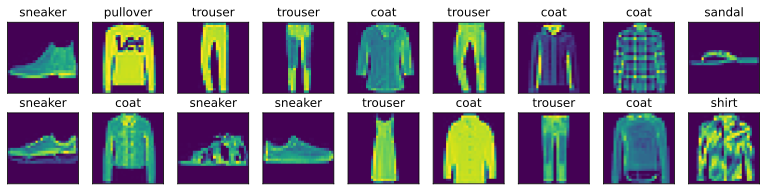

In [31]:
X, y = next(iter(test_iter))
Y_pred = []
for sample in X:
    Y_pred.append(predict(AM, sample, position_IM, grayscale_IM, dim))
fig.show_mnist_images(X.reshape(batch_size, 28, 28), 2, 9, titles=preData.get_fashion_mnist_labels(Y_pred))